## Illustration of bias and variance using simulations from the data generating process
To illustrate the concepts of bias and variance of a fitted regression model, I will here:

* Simulate many datasets from a nonlinear data generating process: $y = f_\star(x) + \varepsilon$.
* Fit a polynomial to each data set
* Visualize the bias and variance by plotting all the estimates and the true regression curve.

First, we set up a function for the simulator (data generating process).

In [169]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap

np.random.seed(seed=25) # Set the seed for reproducibility

brewer_cmap = ListedColormap(sns.color_palette("Paired"))

# Define the data generating process: 
# y = w0 + w1*basisFunc(x) + eps, where eps~N(0,sigmaEps²)
# basisFunc can be any function you want
def Simulator(n, basisFunc, w, sigmaEps = 1):
    X = np.random.uniform(0,1,(n,1))
    xBasis = basisFunc(X)
    y = w[0] + w[1]*xBasis + sigmaEps*np.random.normal(size=(n,1))
    return((X,y))

Let's simulate a dataset from the data generating process and plot it

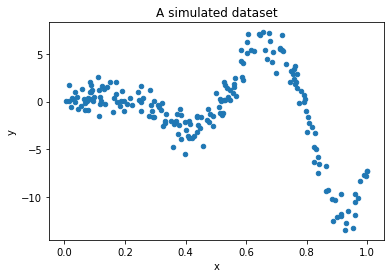

In [2]:
n = 200
sigmaEps = 1
w = np.array([0,5])
basisFunc = lambda x : x*np.sin(12*x)*np.exp(x) # Setting up a basis function using Python's lambda (inline function)
X,y = Simulator(n, basisFunc, w, sigmaEps)
plt.scatter(X,y, s = 20, cmap = brewer_cmap);
plt.xlabel('x');plt.ylabel('y');plt.title('A simulated dataset');

Now that we have working simulator, let's simulate many datasets from it and fit polynomial of degree polyDegree to each of them

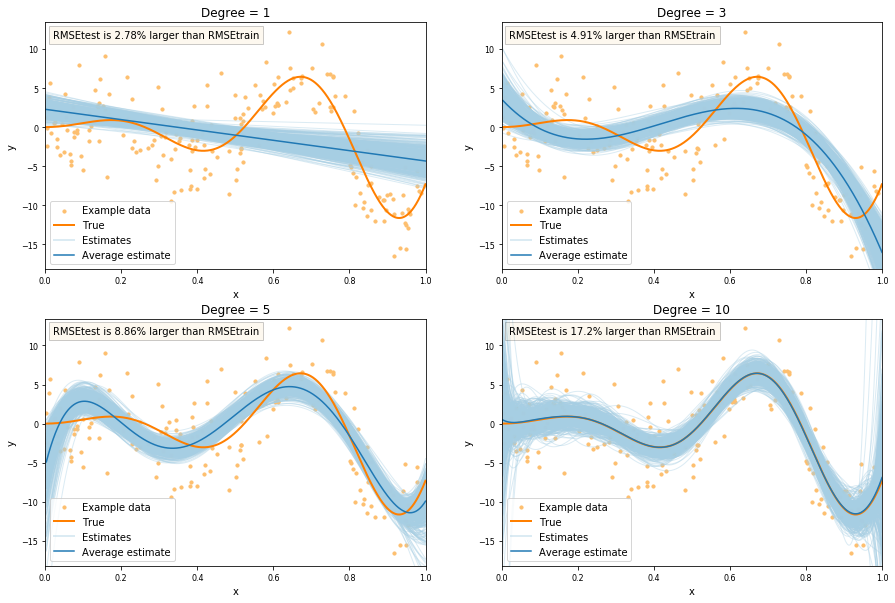

In [156]:
from sklearn import linear_model # submodule with linear models
from sklearn.preprocessing import PolynomialFeatures # Not construct polynomials
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error # Simple function that computes MSE

regModel = linear_model.LinearRegression()
nSim = 500
n = 200
basisFunc = lambda x : x*np.sin(12*x)*np.exp(x) # Setting up a basis function using Python's lambda (inline function)
sigmaEps = 3
w = np.array([0,5])
polyDegrees = (1,3,5,10)
testSize = 0.5 # Fraction test data

fig, ax = plt.subplots(2, 2, figsize=(15, 10))

xGrid = np.linspace(np.min(X),np.max(X),1000)
xGrid = xGrid.reshape(-1,1) # Convert it to matrix, as required by the predict method.
RMSEtrain = np.zeros((nSim,len(polyDegrees)))
RMSEtest = np.zeros((nSim,len(polyDegrees)))
meanFit = np.zeros((len(xGrid),len(polyDegrees)))
meanSquaredFit = np.zeros((len(xGrid),len(polyDegrees)))

X,y = Simulator(n, basisFunc, w, sigmaEps) # Just get one dataset for plotting

for i in range(nSim):
    X,y = Simulator(n, basisFunc, w, sigmaEps)
    xTrain, xTest, yTrain, yTest = train_test_split(X, y, test_size = testSize)
    for count, polyDegree in enumerate(polyDegrees):
        poly = PolynomialFeatures(degree=polyDegree, include_bias=False)
        xBasisTrain = poly.fit_transform(xTrain)
        regModel.fit(X = xBasisTrain, y = yTrain)
    
        # RMSE training
        yPredTrain = regModel.predict(X = xBasisTrain)
        RMSEtrain[i,count] = np.sqrt(mean_squared_error(yTrain, yPredTrain))

        # Plotting the fit
        xGridBasis = poly.fit_transform(xGrid)
        yFit = regModel.predict(X = xGridBasis)
        fitLine, = ax.flat[count].plot(xGrid, yFit, c = brewer_cmap.colors[0], alpha = 0.4, linewidth = 1);
        meanFit[:,count] = meanFit[:,count] + yFit.T
        meanSquaredFit[:,count] = meanSquaredFit[:,count] + (yFit.T)**2

        # Prediction on test data
        xBasisTest = poly.fit_transform(xTest)
        yPredTest = regModel.predict(X = xBasisTest)
        RMSEtest[i,count] = np.sqrt(mean_squared_error(yTest, yPredTest))
        
meanFit = meanFit/nSim # Mean fit over all datasets
meanSquaredFit = meanSquaredFit/nSim # Mean of squared fit over all datasets
varFit = meanSquaredFit - meanFit**2

for count,polyDegree in enumerate(polyDegrees):
    # Plot the data
    data = ax.flat[count].scatter(X, y, s = 10, c = brewer_cmap.colors[6:7])

    # Plot the true function     
    trueMean = w[0] + w[1]*basisFunc(xGrid)
    trueLine, = ax.flat[count].plot(xGrid, trueMean, c = brewer_cmap.colors[7], linewidth = 2)

    # Plot the sample mean of the estimates
    meanLine, = ax.flat[count].plot(xGrid, meanFit[:,count], c =  brewer_cmap.colors[1]);

    ax.flat[count].set_title('Degree = '+str(polyDegrees[count]) , fontsize=12);
    ax.flat[count].set_xlabel('x')
    ax.flat[count].set_ylabel('y')
    ax.flat[count].set_ylim(np.min(y)*1.1, np.max(y)*1.1);
    ax.flat[count].set_xlim(0,1);
    #ax[count].set_rc('xtick', labelsize=8)
    #ax[count].set_rc('ytick', labelsize=8)
    leg = ax.flat[count].legend((data, trueLine, fitLine, meanLine),('Example data','True','Estimates','Average estimate'), loc = 'lower left', fontsize = 10)
    leg.get_lines()[1].set_linewidth(2)
    textStr = 'RMSEtest is ' + str(np.round(np.mean((RMSEtest[:,count]-RMSEtrain[:,count])/RMSEtrain[:,count])*100,2)) +"%" + ' larger than RMSEtrain'
    props = dict(facecolor='wheat', alpha=0.2)
    ax.flat[count].text(0.02, 0.97, textStr, transform=ax.flat[count].transAxes, fontsize=10, verticalalignment='top', bbox=props)

plt.savefig('polyRepeatDataPlusMean.pdf')

Let's plot:

* absolute bias: $\vert \mathrm{Bias}(x)\vert = \vert \mathbb{E}\hat f(x)-f_{\star}(x)\vert $
* standard deviation of the estimator: $\mathrm{Stdev}(x) = \sqrt{\mathbb{V}(\hat f(x))}$ and 
* Mean Squared Error: $\mathrm{MSE} = \big( \hat f(x) - f_{\star}(x)\big)^2 = \mathbb{V}(\hat f(x)) +  \mathrm{Bias}^2(x)$

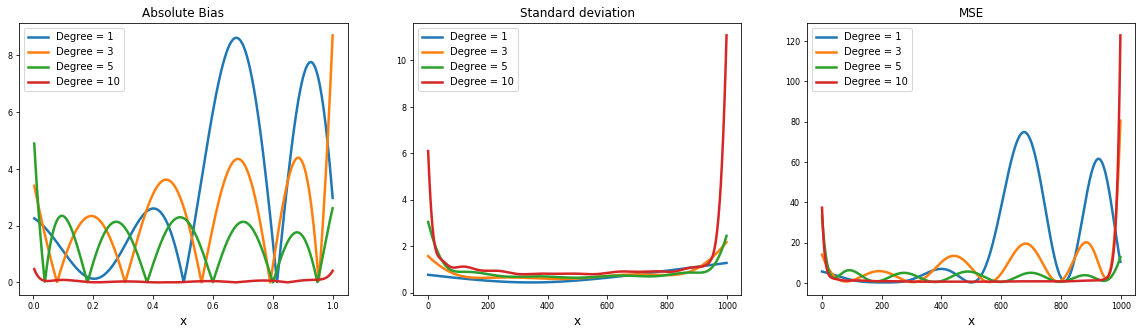

In [173]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
legendText = [str('Degree = ') + str(polyDegree) for polyDegree in polyDegrees]

# Squared Bias
ax[0].plot(xGrid,np.abs(meanFit-trueMean), linewidth = 2.5)
ax[0].set_title('Absolute Bias', fontsize=12);
ax[0].set_xlabel('x', fontsize=12)
ax[0].set_ylabel('')
leg = ax[0].legend(legendText, loc = 'upper left', fontsize = 10)

# Std deviation
ax[1].plot(np.sqrt(varFit), linewidth = 2.5)
ax[1].set_title('Standard deviation', fontsize=12);
ax[1].set_xlabel('x', fontsize=12)
ax[1].set_ylabel('')
leg = ax[1].legend(legendText, loc = 'upper left', fontsize = 10)

# MSE
ax[2].plot(varFit + (meanFit-trueMean)**2, linewidth = 2.5)
ax[2].set_title('MSE', fontsize=12);
ax[2].set_xlabel('x', fontsize=12)
ax[2].set_ylabel('')
leg = ax[2].legend(legendText, loc = 'upper left', fontsize = 10)

plt.savefig('polyRepeatBiasVariance.pdf')